In [1]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import numpy as np

In [2]:
user = getpass.getuser()

src = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/"
nifti_paths = list(Path(src).glob('Nifti/**/*.nii'))
mask_r_paths = list(Path(src).glob('**/mask_R.nii.gz'))
mask_l_paths = list(Path(src).glob('**/mask_L.nii.gz'))

In [3]:
def save_nib_file(path, nft, nft_affine):
    nft_2_save = nib.Nifti1Image(nft, nft_affine)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nib.save(nft_2_save, path)


def calibrate_color_values(nft_imgs, low_cv = -1024, high_cv = 250):

    calibrated_values = nft_imgs.copy()
    for i, im in enumerate(calibrated_values):
        if any(any(c > high_cv or c < low_cv for c in r) for r in im):
            calibrated_values[i] = [[max(min(c, high_cv), low_cv) for c in r] for r in im]

    return ((calibrated_values - low_cv) / (high_cv-low_cv)) * 255

def get_z_start_stop(mask):
    start_z = 0

    for z in range(mask.shape[2]):
        if mask[:,:,z].any():
            start_z = z
            break

    stop_z = mask.shape[2]

    for z in reversed(range(mask.shape[2])):
        if mask[:,:,z].any():
            stop_z = z
            break

    return start_z, stop_z


def get_x_start_stop(mask):
    start_x = 0

    for x in range(mask.shape[0]):
        if mask[x,:,:].any():
            start_x = x
            break

    stop_x = mask.shape[0]

    for x in reversed(range(mask.shape[0])):
        if mask[x,:,:].any():
            stop_x = x
            break

    return start_x, stop_x

def get_y_start_stop(mask):
    start_y = 0

    for y in range(mask.shape[1]):
        if mask[:,y,:].any():
            start_y = y
            break

    stop_y = mask.shape[1]

    for y in reversed(range(mask.shape[1])):
        if mask[:,y,:].any():
            stop_y = y
            break

    return start_y, stop_y

def generate_chunks(nft, mask_l, mask_r, dst_path, chunk_size=17, spacing=4):

    masks = [mask_l, mask_r]

    print("fetching data and calibrating values")
    nft_data = nft.get_fdata()

    #calibrated_values = calibrate_color_values(nft.get_fdata())

    file_name_list = ["L", "R"]

    for i, mask in enumerate(masks):
        
        start_z, stop_z = get_z_start_stop(mask)

        print("generating chunks for lung ", file_name_list[i])

        for z in range(start_z + chunk_size * spacing, stop_z - chunk_size*spacing, chunk_size * spacing):

            start_x, stop_x = get_x_start_stop(mask[:,:, z : z + chunk_size])
            start_y, stop_y = get_y_start_stop(mask[:,:, z : z + chunk_size])

            chunk = calibrate_color_values(nft_data[start_x:stop_x, start_y:stop_y, z : z + chunk_size])

            save_nib_file(dst_path + f"/{file_name_list[i]}_{z}_{z+chunk_size}.nii", chunk, nft.affine)    

In [4]:
def main():
    for nifti_path, mask_r_path, mask_l_path in zip(nifti_paths[:1], mask_r_paths[:1], mask_l_paths[:1]):

        nft = nib.load(nifti_path)

        mask_r = nib.load(mask_r_path).get_fdata()
        mask_l = nib.load(mask_l_path).get_fdata()

        path = src + 'Preprocessed/' + nifti_path.stem
        
        generate_chunks(nft, mask_l, mask_r, path)

main()

fetching data and calibrating values
generating chunks for lung  L
generating chunks for lung  R


[[198.355573   227.57849294 255.         ... 233.98351648 226.17739403
  204.96075353]
 [222.3744113  255.         255.         ... 238.78728414 237.78649922
  208.36342229]
 [221.97409733 255.         255.         ... 222.77472527 231.18131868
  201.1577708 ]
 ...
 [187.34693878 190.34929356 177.1389325  ... 208.76373626 203.15934066
  187.74725275]
 [175.73783359 181.94270016 172.73547881 ... 200.55729984 191.14992151
  192.15070644]
 [174.13657771 192.15070644 189.54866562 ... 184.54474097 179.54081633
  203.15934066]]


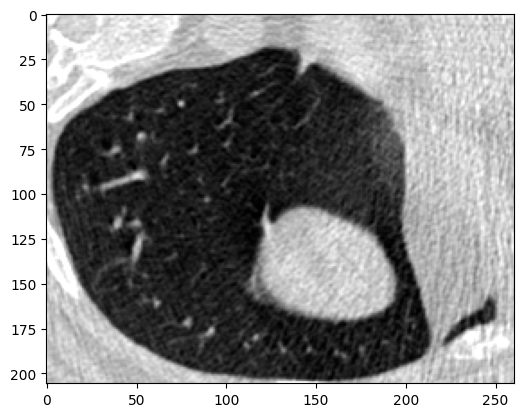

In [5]:
import matplotlib.pyplot as plt
nisan = nib.load(src + 'Preprocessed2/1001_bwt/L_115_132.nii').get_fdata()
plt.imshow(nisan[:,:,0], cmap='gray')